In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
#from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
# parameters
mu1, sigma1, mu2, sigma2 = -0.5, 0.2, 0.5, 0.2
data_range = 1

# Size of input
input_size = 1000
# Size of latent vector to generator
z_size = 50
# Sizes of hidden layers
n_hidden = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

d_learning_rate = 0.002
g_learning_rate = 0.002
n_epochs = 300
M = 100 # batch size

In [3]:
class DataDistribution(object):
    def __init__(self, mu1, sigma1, mu2, sigma2):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2

    def sample(self, N):
        half_N = N // 2
        samples1 = np.random.normal(self.mu1, self.sigma1, half_N)
        samples2 = np.random.normal(self.mu2, self.sigma2, half_N)
        samples = np.concatenate((samples1, samples2))
        samples.sort()
        return samples

In [4]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

In [5]:
# G(z)
def generator(z, out_dim, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # hidden layer
        h1 = tf.layers.dense(z, n_hidden, activation=None)
        # leacky ReLU
        h1 = tf.maximum(alpha * h1, h1)

        # logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        return out

In [6]:
# D(x)
def discriminator(x, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer
        h1 = tf.layers.dense(x, n_hidden, activation=None)
        # leacky ReLU
        h1 = tf.maximum(alpha * h1, h1)

        # logits and tanh output
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

# Build Net

In [7]:
tf.reset_default_graph()

# Create our input placeholders
inputs_z = tf.placeholder(tf.float32, shape=[None, z_size], name='inputs_z')
inputs_real = tf.placeholder(tf.float32, shape=[None, input_size], name='inputs_real')

# Build the model
g_model = generator(inputs_z, out_dim=input_size, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_real, d_logits_real = discriminator(inputs_real, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, n_hidden=n_hidden, reuse=True, alpha=alpha)

In [8]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [9]:
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)

In [10]:
data = DataDistribution(mu1, sigma1, mu2, sigma2)
gen = GeneratorDistribution(data_range)

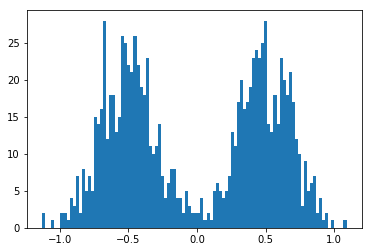

In [11]:
temp_x = data.sample(input_size)
plt.hist(temp_x, bins=100)
plt.show()

In [12]:
samples = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        x_ = data.sample(M * input_size) # sampled m-batch from p_data
        x_ = np.reshape(x_, [M, input_size])
        z_ = gen.sample(M * z_size)  # sample m-batch from noise prior
        z_ = np.reshape(z_, [M, z_size])
        
        # Run optimizers
        _ = sess.run(d_train_opt, feed_dict={inputs_real: x_, inputs_z: z_})
        _ = sess.run(g_train_opt, feed_dict={inputs_z: z_})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_real: x_, inputs_z: z_})
        train_loss_g = g_loss.eval({inputs_z: z_})
        
        print("Epoch {}/{}...".format(e+1, n_epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = gen.sample(z_size)
        sample_z = np.reshape(sample_z, [1, z_size])
        gen_samples = sess.run(
                       generator(inputs_z, out_dim=input_size, n_hidden=n_hidden, reuse=True),
                       feed_dict={inputs_z: sample_z})
        samples.append(gen_samples)

Epoch 1/300... Discriminator Loss: 2.0091... Generator Loss: 0.3836
Epoch 2/300... Discriminator Loss: 2.1443... Generator Loss: 0.2869
Epoch 3/300... Discriminator Loss: 2.4186... Generator Loss: 0.2432
Epoch 4/300... Discriminator Loss: 2.4997... Generator Loss: 0.2250
Epoch 5/300... Discriminator Loss: 2.4735... Generator Loss: 0.2258
Epoch 6/300... Discriminator Loss: 2.4363... Generator Loss: 0.2511
Epoch 7/300... Discriminator Loss: 2.0908... Generator Loss: 0.3061
Epoch 8/300... Discriminator Loss: 1.6904... Generator Loss: 0.3995
Epoch 9/300... Discriminator Loss: 1.3241... Generator Loss: 0.5693
Epoch 10/300... Discriminator Loss: 1.0218... Generator Loss: 0.8227
Epoch 11/300... Discriminator Loss: 0.8177... Generator Loss: 1.1093
Epoch 12/300... Discriminator Loss: 0.7244... Generator Loss: 1.3145
Epoch 13/300... Discriminator Loss: 0.7554... Generator Loss: 1.3716
Epoch 14/300... Discriminator Loss: 0.8057... Generator Loss: 1.2800
Epoch 15/300... Discriminator Loss: 0.8568.

Epoch 121/300... Discriminator Loss: 0.4761... Generator Loss: 4.2962
Epoch 122/300... Discriminator Loss: 0.4751... Generator Loss: 4.3066
Epoch 123/300... Discriminator Loss: 0.4711... Generator Loss: 4.3541
Epoch 124/300... Discriminator Loss: 0.4663... Generator Loss: 4.4377
Epoch 125/300... Discriminator Loss: 0.4612... Generator Loss: 4.5357
Epoch 126/300... Discriminator Loss: 0.4546... Generator Loss: 4.6912
Epoch 127/300... Discriminator Loss: 0.4493... Generator Loss: 4.9216
Epoch 128/300... Discriminator Loss: 0.4481... Generator Loss: 5.0967
Epoch 129/300... Discriminator Loss: 0.4501... Generator Loss: 5.2225
Epoch 130/300... Discriminator Loss: 0.4552... Generator Loss: 5.3053
Epoch 131/300... Discriminator Loss: 0.4541... Generator Loss: 5.4402
Epoch 132/300... Discriminator Loss: 0.4519... Generator Loss: 5.6420
Epoch 133/300... Discriminator Loss: 0.4523... Generator Loss: 5.8629
Epoch 134/300... Discriminator Loss: 0.4544... Generator Loss: 6.0016
Epoch 135/300... Dis

Epoch 240/300... Discriminator Loss: 0.5530... Generator Loss: 2.3815
Epoch 241/300... Discriminator Loss: 0.5420... Generator Loss: 2.4519
Epoch 242/300... Discriminator Loss: 0.5298... Generator Loss: 2.5067
Epoch 243/300... Discriminator Loss: 0.5213... Generator Loss: 2.5600
Epoch 244/300... Discriminator Loss: 0.5148... Generator Loss: 2.6118
Epoch 245/300... Discriminator Loss: 0.5105... Generator Loss: 2.6519
Epoch 246/300... Discriminator Loss: 0.5072... Generator Loss: 2.6734
Epoch 247/300... Discriminator Loss: 0.5045... Generator Loss: 2.6957
Epoch 248/300... Discriminator Loss: 0.5018... Generator Loss: 2.6943
Epoch 249/300... Discriminator Loss: 0.5010... Generator Loss: 2.6872
Epoch 250/300... Discriminator Loss: 0.5020... Generator Loss: 2.6742
Epoch 251/300... Discriminator Loss: 0.5028... Generator Loss: 2.6928
Epoch 252/300... Discriminator Loss: 0.4961... Generator Loss: 2.7659
Epoch 253/300... Discriminator Loss: 0.4844... Generator Loss: 2.8551
Epoch 254/300... Dis

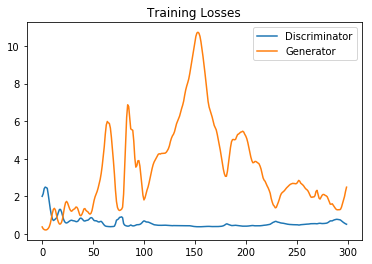

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [14]:
last_sample = samples[-1]
print(last_sample.shape)

(1, 1000)


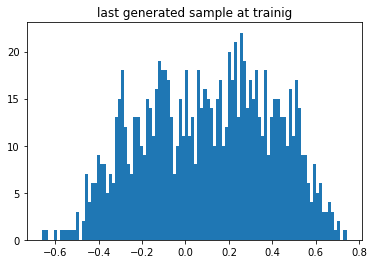

In [18]:
plt.hist(last_sample.T, bins=100)
plt.title('last generated sample at trainig')